In [30]:
import osmnx as ox
import random
from shapely.geometry import Point
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random

#bb cordinates
north, south, east, west = 29.7700, 29.7500, -95.3500, -95.4000
# Download graph
G_small = ox.graph_from_bbox(north, south, east, west, network_type='drive')

#making danger scores
for u, v, data in G_small.edges(data=True):
    data['danger'] = data.get('danger', random.randint(1, 10)) 
    
# Define classes
class Hospital: 
    def __init__(self, location, capacity):
        self.location = location  # Nearest node in the road network
        self.capacity = capacity  # Maximum number of victims it can handle at once

class Victim: 
    def __init__(self, location, rating): 
        self.location = location  # Nearest node in the road network
        self.rating = rating      # 'R' for red (critical), 'G' for green (less critical), 'U' for unknown
        self.visited = False      # Track if a victim has already been visited

class Vehicle:
    def __init__(self, location, type, max_risk, capacity, current_amt, index):
        self.type = type           # Type of vehicle: ambulance, helicopter, etc.
        self.max_risk = max_risk  # Max risk level the vehicle can handle
        self.location = location  # Nearest node in the road network
        self.capacity = capacity  # How many people (green) victims known at once
        self.current_amt = current_amt  # How many people are currently in it
        self.route = []
        self.risk_scores = []
        self.index = index

# Bounding box coordinates (the area you are working with)
north, south, east, west = 29.7700, 29.7500, -95.3500, -95.4000

# Load the road network for the bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Function to find the nearest node in the graph for a given location
def get_nearest_node(location):
    # Create a point geometry from the (latitude, longitude) location
    point = Point(location[1], location[0])  # OSMnx uses (longitude, latitude)
    nearest_node = ox.distance.nearest_nodes(G, X=point.x, Y=point.y)
    return nearest_node

hospitals = []
victims = []
vehicles = []

# Randomly generate hospitals with random locations and capacities
for _ in range(5):
    lat = random.uniform(south, north)
    lon = random.uniform(west, east)
    capacity = random.randint(10, 50)  # Random capacity
    nearest_node = get_nearest_node((lat, lon))  # Get the nearest node in the road network
    hospitals.append(Hospital(location=nearest_node, capacity=capacity))

# Randomly generate  victims with random locations and ratings
ratings = ['R', 'G', 'U']  # Red, Green, Unknown
for _ in range(15):
    lat = random.uniform(south, north)
    lon = random.uniform(west, east)
    rating = random.choice(ratings)
    nearest_node = get_nearest_node((lat, lon))  # Get the nearest node in the road network
    victims.append(Victim(location=nearest_node, rating=rating))

# Randomly generate vehicles with random locations, max_risk, and capacity
vehicle_types = ['ambulance', 'helicopter', 'rescue_truck']
idx = 1  # Initialize index for vehicles
for _ in range(4):
    lat = random.uniform(south, north)
    lon = random.uniform(west, east)   
    vehicle_type = random.choice(vehicle_types)
    
    # Set max_risk based on vehicle type
    if vehicle_type == 'ambulance':
        max_risk = 5  # Ambulance has max risk of 5
    elif vehicle_type == 'rescue_truck':
        max_risk = 7  # Rescue truck has max risk of 7
    else:
        max_risk = 10  # Helicopter has max risk of 10
    
    capacity = random.randint(1, 4)  # Random capacity for the vehicle
    current_amt = 0  # Start with no victims in the vehicle
    hospital = random.choice(hospitals)  # Assign the starting location to a random hospital
    nearest_node = hospital.location  # It must begin at a hospital
    
    # Create a vehicle and append it to the list
    vehicles.append(
        Vehicle(location=nearest_node, type=vehicle_type, max_risk=max_risk, capacity=capacity, current_amt=current_amt, index=idx)
    )
    
    idx += 1  # Increment the index for the next vehicle


# Output the information about the hospitals, victims, and vehicles
print("Hospitals:")
for hospital in hospitals:
    print(f"Location (Node): {hospital.location}, Capacity: {hospital.capacity}")

print("\nVictims:")
for victim in victims:
    print(f"Location (Node): {victim.location}, Rating: {victim.rating}, Visited: {victim.visited}")

print("\nVehicles:")
for vehicle in vehicles:
    print(f"Type: {vehicle.type}, Location (Node): {vehicle.location}, Max Risk: {vehicle.max_risk}, "
          f"Capacity: {vehicle.capacity}, Current Amount: {vehicle.current_amt}")

import osmnx as ox
import networkx as nx
import random
alpha =1 
beta = 0.2
# Modify the vehicle_risk function to return time and risk as well
def vehicle_risk(u, v, data, vehicle_type, vehicle_max_risk=5, alpha=1, beta=0.5):
    # Define different risk thresholds for different vehicles
    if vehicle_type == 'ambulance':
        vehicle_max_risk = 5
        speed = 15  # m/s
    elif vehicle_type == 'helicopter':
        vehicle_max_risk = 10  # Helicopters can avoid some dangers (e.g., traffic)
        speed = 70  # m/s
    elif vehicle_type == 'rescue_truck':
        vehicle_max_risk = 7  # Rescue trucks may be slower but more robust
        speed = 10  # m/s (

    # Get distance (length of the edge) in meters
    distance = data.get('length', 1)  # Default to 1 if no length is available
    time = distance / speed
    
    # Get danger
    temp_danger = data.get('danger', 0)
    
    # If the risk (danger) is above the threshold, make the edge inaccessible
    if temp_danger > vehicle_max_risk:
        return float('inf'), 0, 0  # Inaccessible if danger is too high (time=0, risk=0) - 1:09 pm (maybe change this to inf) 
    
    # combined weight/score as a linear combination of time and danger
    combined_weight = alpha * time + beta * temp_danger
    return combined_weight, time, temp_danger  # Return time and danger in addition to the combined weight

# Apply the modified vehicle_risk function to set edge weights and store time and risk values
for u, v, data in G_small.edges(data=True):
    data['weight_ambulance'], data['time_ambulance'], data['risk_ambulance'] = vehicle_risk(u, v, data, 'ambulance')
    data['weight_helicopter'], data['time_helicopter'], data['risk_helicopter'] = vehicle_risk(u, v, data, 'helicopter')
    data['weight_rescue_truck'], data['time_rescue_truck'], data['risk_rescue_truck'] = vehicle_risk(u, v, data, 'rescue_truck')

# Create the matrices (dictionary of dictionaries) for each vehicle type
vehicle_matrices = {'ambulance': {}, 'helicopter': {}, 'rescue_truck': {}}

# Extract locations (node IDs) from both victims and hospitals
all_locations = [victim.location for victim in victims] + [hospital.location for hospital in hospitals]

# Initialize the vehicle_matrices with invalid entries
for vehicle_type in vehicle_matrices:
    for location1 in all_locations:
        vehicle_matrices[vehicle_type][location1] = {}
        for location2 in all_locations:
            if location1 == location2:
                vehicle_matrices[vehicle_type][location1][location2] = {'score': 0, 'time': 0, 'risk': 0, 'path': []}  # Invalid (same location)
            else:
                try:
                    # Find the shortest path between location1 and location2 using Dijkstra's algorithm
                    shortest_path = nx.dijkstra_path(G_small, source=location1, target=location2, weight=f'weight_{vehicle_type}')
                    total_risk = 0
                    total_time = 0
                    total_distance = 0

                    # Calculate total risk, time, and total distance along the path
                    for i in range(len(shortest_path) - 1):
                        u = shortest_path[i]
                        v = shortest_path[i + 1]
                        total_risk += G_small[u][v][0].get(f'risk_{vehicle_type}', 0)
                        total_time += G_small[u][v][0].get(f'time_{vehicle_type}', 0)
                        total_distance += G_small[u][v][0].get('length', 0)

                    # Save the results in the matrix
                    vehicle_matrices[vehicle_type][location1][location2] = {
                        'score': total_time + total_risk*0.5,  # Calculate weighted score - change as necessary
                        'time': total_time,
                        'risk': total_risk,
                        'path': shortest_path  # Save the shortest path
                    }
                except nx.NetworkXNoPath:
                    # If no path is found, set the value to None
                    vehicle_matrices[vehicle_type][location1][location2] = {'score': None, 'time': None, 'risk': None, 'path': None}
# Output the vehicle_matrices for each vehicle type
for vehicle_type in vehicle_matrices:
    print(f"Vehicle Type: {vehicle_type}")
    
    # Iterate over each location pair
    for location1 in vehicle_matrices[vehicle_type]:
        for location2 in vehicle_matrices[vehicle_type][location1]:
            result = vehicle_matrices[vehicle_type][location1][location2]
            if result['score'] is not None:
                print(f"From Node {location1} to Node {location2}: ")
                print(f"  Score: {result['score']}")
                print(f"  Time: {result['time']} seconds")
                print(f"  Risk: {result['risk']}")
                print(f"  Path: {result['path']}")
            else:
                print(f"No path from Node {location1} to Node {location2}")
    
    print("\n" + "-"*40)


/var/folders/j0/y6d4361s4c3gs1wcm65ym00w0000gn/T/ipykernel_82142/620109136.py:12: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G_small = ox.graph_from_bbox(north, south, east, west, network_type='drive')
/var/folders/j0/y6d4361s4c3gs1wcm65ym00w0000gn/T/ipykernel_82142/620109136.py:12: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G_small = ox.graph_from_bbox(north, south, east, west, network_type='drive')
/var/folders/j0/y6d4361s4c3gs1wcm65ym00w0000gn/T/ipykernel_82142/620109136.py:45: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues

Hospitals:
Location (Node): 152252194, Capacity: 27
Location (Node): 3116217940, Capacity: 36
Location (Node): 152453836, Capacity: 24
Location (Node): 152853852, Capacity: 37
Location (Node): 152761125, Capacity: 11

Victims:
Location (Node): 152675993, Rating: G, Visited: False
Location (Node): 153047048, Rating: U, Visited: False
Location (Node): 152327880, Rating: U, Visited: False
Location (Node): 9546750043, Rating: R, Visited: False
Location (Node): 1420317130, Rating: U, Visited: False
Location (Node): 9546750043, Rating: G, Visited: False
Location (Node): 152700482, Rating: R, Visited: False
Location (Node): 153276667, Rating: R, Visited: False
Location (Node): 2637464617, Rating: G, Visited: False
Location (Node): 1197440961, Rating: U, Visited: False
Location (Node): 152478685, Rating: U, Visited: False
Location (Node): 8010944256, Rating: R, Visited: False
Location (Node): 152772198, Rating: U, Visited: False
Location (Node): 153002510, Rating: R, Visited: False
Location (N

In [ ]:
import random

# Define parameters
evaporation_rate = 0.05 # Pheromone evaporation rate
alpha = 2               # Influence of pheromone
beta = 3                # Influence of heuristic (distance, score, etc.)
initial_pheromone = 1.0

locations = [victim.location for victim in victims] + [hospital.location for hospital in hospitals]
num_locations = len(locations)


# Initialize pheromone matrix
pheromones = [[initial_pheromone for _ in range(num_locations)] for _ in range(num_locations)]

# Ensure vehicles have starting locations
for vehicle in vehicles:
    if not hasattr(vehicle, "location") or vehicle.location not in locations:
        raise ValueError(f"Vehicle {vehicle} has an invalid or missing starting location.")

def calculate_total_score_and_time(vehicle_routes, vehicle_type, vehicle_matrices, locations):
    total_score = 0
    total_time = 0
    
    for vehicle_route in vehicle_routes:
        for i in range(len(vehicle_route) - 1):
            from_index = locations.index(vehicle_route[i])
            to_index = locations.index(vehicle_route[i + 1])
            
            total_score += vehicle_matrices[vehicle_type][vehicle_route[i]][vehicle_route[i + 1]]['score']
            total_time += vehicle_matrices[vehicle_type][vehicle_route[i]][vehicle_route[i + 1]]['time']
    
    return total_score, total_time

def ant_colony_optimization_multiple_vehicles():
    num_iterations = 100
    best_routes = None
    best_score = float('inf')
    lowest_total_time = float('inf')
    best_time_routes = None
    num_ants = len(vehicles)
    num_vehicles = len(vehicles)
    score_progression = []
    time_progression = []

    for iteration in range(num_iterations):
        print(f"--- Iteration {iteration + 1} ---")
        all_routes = []
        all_scores = []
        all_times = []

        # Move ants (representing vehicles) and evaluate routes
        for ant in range(num_ants):
            print(f"  Ant {ant + 1} starting route:")
            vehicle_routes = [[] for _ in range(num_vehicles)]  # One route per vehicle
            visited = set()

            # Assign locations to vehicles
            while len(visited) < num_locations:
                for vehicle_idx in range(num_vehicles):
                    if len(visited) < num_locations:
                        current_location = vehicle_routes[vehicle_idx][-1] if vehicle_routes[vehicle_idx] else vehicles[vehicle_idx].location
                        
                        # Filter possible moves
                        possible_moves = [loc for loc in locations if loc not in visited]
                        if possible_moves:
                            probabilities = []
                            for next_loc in possible_moves:
                                from_idx = locations.index(current_location)
                                to_idx = locations.index(next_loc)
                                #how does pheromones work?
                                pheromone = pheromones[from_idx][to_idx] ** alpha
                                print(f"from_idx: {from_idx}, to_idx: {to_idx}, current_location: {current_location}, next_loc: {next_loc}")
                                heuristic = (1 / (vehicle_matrices[vehicles[vehicle_idx].type][current_location][next_loc]['score'] + 1)) ** beta
                                probabilities.append(pheromone * heuristic)

                            # Normalize probabilities
                            total_prob = sum(probabilities)
                            probabilities = [p / total_prob for p in probabilities] if total_prob > 0 else probabilities

                            # Choose the next location
                            next_location = random.choices(possible_moves, probabilities)[0]
                            vehicle_routes[vehicle_idx].append(next_location)
                            visited.add(next_location)
                            print(f"Vehicle {vehicle_idx} moves to {next_location}")

            # Evaluate routes
            total_score, total_time = calculate_total_score_and_time(vehicle_routes, vehicles[0].type, vehicle_matrices, locations)
            all_routes.append(vehicle_routes)
            all_scores.append(total_score)
            all_times.append(total_time)

            print(f"    Routes completed: {vehicle_routes}")
            print(f"    Score for this set of routes: {total_score}, Time: {total_time}")

            if total_score < best_score:
                best_score = total_score
                best_routes = vehicle_routes
                print(f"    New best routes found with score {best_score}: {best_routes}")
            
            if total_time < lowest_total_time:
                lowest_total_time = total_time
                best_time_routes = vehicle_routes
                print(f"    New best time routes found with time {lowest_total_time}: {best_time_routes}")

        # Update pheromones
        pheromone_delta = [[0 for _ in range(num_locations)] for _ in range(num_locations)]
        for i, vehicle_routes in enumerate(all_routes):
            for vehicle_route in vehicle_routes:
                for j in range(len(vehicle_route) - 1):
                    from_index = locations.index(vehicle_route[j])
                    to_index = locations.index(vehicle_route[j + 1])
                    pheromone_delta[from_index][to_index] += 1.0 / all_scores[i]

        # Apply evaporation and update pheromones
        for i in range(num_locations):
            for j in range(num_locations):
                pheromones[i][j] *= (1 - evaporation_rate)
                pheromones[i][j] += pheromone_delta[i][j]
        
        score_progression.append(min(all_scores))  # Best score in current iteration
        time_progression.append(min(all_times))    # Best time in current iteration

    return best_routes, best_score, best_time_routes, lowest_total_time, score_progression, time_progression

# Run ACO for multiple vehicles
best_routes, best_score, best_time_routes, lowest_total_time, score_progression, time_progression = ant_colony_optimization_multiple_vehicles()

# Output results
print("\nBest Routes (Score):", best_routes)
print("Best Score:", best_score)
print("\nBest Routes (Time):", best_time_routes)
print("Lowest Total Time:", lowest_total_time)


--- Iteration 1 ---
  Ant 1 starting route:
from_idx: 24, to_idx: 0, current_location: 152761125, next_loc: 152675993
from_idx: 24, to_idx: 1, current_location: 152761125, next_loc: 153047048
from_idx: 24, to_idx: 2, current_location: 152761125, next_loc: 152327880
from_idx: 24, to_idx: 3, current_location: 152761125, next_loc: 9546750043
from_idx: 24, to_idx: 4, current_location: 152761125, next_loc: 1420317130
from_idx: 24, to_idx: 3, current_location: 152761125, next_loc: 9546750043
from_idx: 24, to_idx: 6, current_location: 152761125, next_loc: 152700482
from_idx: 24, to_idx: 7, current_location: 152761125, next_loc: 153276667
from_idx: 24, to_idx: 8, current_location: 152761125, next_loc: 2637464617
from_idx: 24, to_idx: 9, current_location: 152761125, next_loc: 1197440961
from_idx: 24, to_idx: 10, current_location: 152761125, next_loc: 152478685
from_idx: 24, to_idx: 11, current_location: 152761125, next_loc: 8010944256
from_idx: 24, to_idx: 12, current_location: 152761125, next_

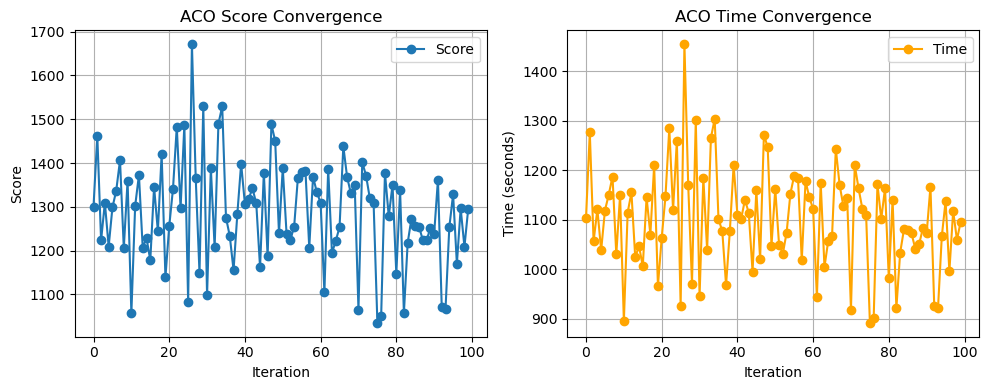

In [26]:
import matplotlib.pyplot as plt

# Plot Score Progression
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(score_progression, marker='o', label='Score')
plt.title('ACO Score Convergence')
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

# Plot Time Progression
plt.subplot(1, 2, 2)
plt.plot(time_progression, marker='o', color='orange', label='Time')
plt.title('ACO Time Convergence')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import random

def generate_random_color():
    """Generates a random color in hex format."""
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return f"#{r:02x}{g:02x}{b:02x}"

def plot_road_network_with_best_routes(G_small, vehicles, vehicle_matrices, victims, hospitals, best_routes):
    """
    Plots the road network along with the best vehicle routes, hospitals, and victims.
    
    Parameters:
    - G_small: NetworkX graph representing the road network
    - vehicles: List of vehicles in the simulation
    - vehicle_matrices: Dictionary containing matrices for vehicles with keys as vehicle types
    - victims: List of victims to be helped
    - hospitals: List of hospitals for vehicle drop-off
    - best_routes: List of routes found by ACO (list of lists of locations per vehicle)
    """
    node_gdf, edge_gdf = ox.graph_to_gdfs(G_small)
    pos = {node: (node_gdf.loc[node, 'x'], node_gdf.loc[node, 'y']) for node in G_small.nodes}

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot base road network
    ox.plot_graph(G_small, ax=ax, node_size=0, bgcolor='lightgray', show=False)

    # Plot the best routes found by ACO
    for vehicle_idx, vehicle_route in enumerate(best_routes):
        color = generate_random_color()
        vehicle_type = vehicles[vehicle_idx].type
        
        # Build edges from the route nodes
        route_edges = [(vehicle_route[i], vehicle_route[i + 1]) for i in range(len(vehicle_route) - 1)]

        # Plot each edge using the stored shortest path in vehicle_matrices
        for edge in route_edges:
            loc1, loc2 = edge
            shortest_path = vehicle_matrices[vehicle_type][loc1][loc2]['path']
            # Draw edges along shortest path
            nx.draw_networkx_edges(
                G_small,
                pos=pos,
                edgelist=[(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)],
                edge_color=color,
                width=3,
                alpha=0.7,
                ax=ax,
                label=f"Vehicle {vehicle_idx} Route"
            )

    # Plot hospitals
    for hospital in hospitals:
        hospital_node = hospital.location
        ax.scatter(pos[hospital_node][0], pos[hospital_node][1], color='blue', s=100, label="Hospital")

    # Plot victims with color based on their rating
    for victim in victims:
        victim_node = victim.location
        if victim.rating == 'U':
            victim_color = 'yellow'
        elif victim.rating == 'G':
            victim_color = 'green'
        else:
            victim_color = 'red'
        ax.scatter(pos[victim_node][0], pos[victim_node][1], color=victim_color, s=100, label=f"Victim ({victim.rating})")

    plt.title("ACO Best Vehicle Routes with Hospitals and Victims")
    plt.show()


/var/folders/j0/y6d4361s4c3gs1wcm65ym00w0000gn/T/ipykernel_82142/411810768.py:46: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


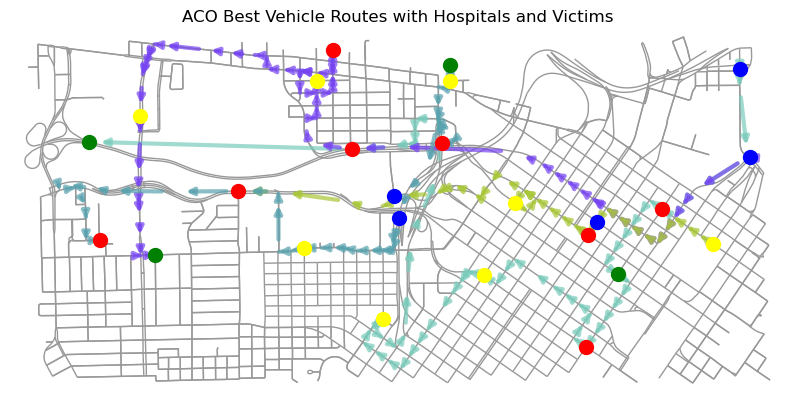

In [28]:
plot_road_network_with_best_routes(G_small, vehicles, vehicle_matrices, victims, hospitals, best_routes)